In [1]:
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

from enum import Enum
from matplotlib import pyplot as plt
from typing import Optional

In [2]:
from google.colab import drive
drive.mount('/content/cdrive')
data_root_dir = 'cdrive/MyDrive/Deep Learning/HW2'
dataset_dir = os.path.join(data_root_dir, 'PennTreeBank')

Mounted at /content/cdrive


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# General Hyperparams

In [ ]:
batch_size=20
seq_length=20
layers=2
rnn_size=200
init_weight=0.1
max_dropout=0.3

# Data Pre-processing

In [4]:
class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
          self.word2idx[word] = self.idx
          self.idx2word[self.idx] = word
          self.idx += 1

    def __len__(self):
        return len(self.word2idx)


class Corpus(object):
    def __init__(self, dictionary: Optional[Dictionary] = None):
        self.is_dictionary_valid = 1 if dictionary else 0
        self.dictionary = dictionary if dictionary else Dictionary()


    def get_data(self, path, batch_size=20):
        # Add words to the dictionary
        with open(path, 'r') as f:
            n_tokens = 0
            for line in f:
                words = line.split() + ['<eos>']
                n_tokens += len(words)
                if not self.is_dictionary_valid:
                  for word in words:
                    self.dictionary.add_word(word)

        # Tokenize the file content
        tokens = torch.LongTensor(n_tokens)
        token = 0
        with open(path, 'r') as f:
            for line in f:
                words = line.split() + ['<eos>']
                for word in words:
                    tokens[token] = self.dictionary.word2idx[word]
                    token += 1
        num_batches = tokens.size(0) // batch_size
        tokens = tokens[:num_batches*batch_size]
        return tokens.view(batch_size, -1)

In [6]:
corpus = Corpus()
training_tokens = corpus.get_data(os.path.join(dataset_dir, 'ptb.train.txt'), batch_size).to(device)
vocab_size = len(corpus.dictionary)

valid_corpus = Corpus(corpus.dictionary)
valid_tokens = valid_corpus.get_data(os.path.join(dataset_dir, 'ptb.valid.txt'), batch_size).to(device)

test_corpus = Corpus(corpus.dictionary)
test_tokens = test_corpus.get_data(os.path.join(dataset_dir, 'ptb.test.txt'), batch_size).to(device)

# Model Architecture

In [7]:
class RecurrentUnit(Enum):
  LSTM = 0,
  GRU = 1

class RNN(nn.Module):
  def __init__(self, dropout: float, unit_type: RecurrentUnit, vocab_size: int, hidden_size: int, init_weight: float, n_layers: int=2):
    super().__init__()

    if unit_type == RecurrentUnit.LSTM:
      constructor = nn.LSTM
    elif unit_type == RecurrentUnit.GRU:
      constructor = nn.GRU
    else:
      raise NotImplementedError

    self.init_weight = init_weight
    self.unit_type = unit_type
    self.n_layers = n_layers
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=hidden_size)
    self.rnn_layers = constructor(input_size=hidden_size,
                                  hidden_size=hidden_size,
                                  num_layers=n_layers,
                                  batch_first=True,
                                  dropout=dropout)

    self.output_layer = nn.Linear(hidden_size, vocab_size)

    self.output_layer.bias.data.zero_()
    self.output_layer.weight.data.uniform_(-init_weight, init_weight)

    self.softmax = nn.LogSoftmax(dim=-1)
    self.reset_parameters()
    self.set_hyperparams(dropout)

  def reset_parameters(self):
        for param in self.parameters():
            nn.init.uniform_(param, -self.init_weight, self.init_weight)

  def forward(self, x, initial_states):
    word = self.embed(x)
    output, states = self.rnn_layers(word, initial_states)
    output = self.output_layer(output)
    return output.view(-1, output.size(2)), states

  def init_states(self, batch_size, device):
    if self.unit_type is RecurrentUnit.LSTM:
      h = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)
      c = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)
      states = (h, c)
    elif self.unit_type is RecurrentUnit.GRU:
      states = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)
    return states

  def detach_states(self, states):
    if self.unit_type is RecurrentUnit.LSTM:
      return [s.detach() for s in states]
    elif self.unit_type is RecurrentUnit.GRU:
      return states.detach()
    else:
      raise NotImplementedError

  def set_hyperparams(self, dropout):
    if dropout == 0 and self.unit_type == RecurrentUnit.LSTM:
      self.n_epochs = 13
      self.decay = 0.5
      self.lr = 50.
      self.epoch_for_lr_decay = 4
      self.max_grad_norm = 0.1

    elif dropout == 0 and self.unit_type == RecurrentUnit.GRU:
      self.n_epochs = 13
      self.decay = 0.5
      self.lr = 10.
      self.epoch_for_lr_decay = 2
      self.max_grad_norm = 0.5

    elif dropout > 0 and self.unit_type == RecurrentUnit.LSTM:
      self.decay = 0.5
      self.lr = 10.
      self.epoch_for_lr_decay = 5
      self.n_epochs = 25

      self.max_grad_norm = 0.5

    elif dropout > 0 and self.unit_type == RecurrentUnit.GRU:
      self.decay = 0.5
      self.lr = 20.
      self.epoch_for_lr_decay = 5
      self.n_epochs = 25

      self.max_grad_norm = 0.1

    else:
      raise NotImplementedError


# Training and Eval Utils

In [8]:
def train(model):
  criterion = nn.CrossEntropyLoss()
  train_ppls, valid_ppls, test_ppls = [], [], []

  for e in range(model.n_epochs):

    if e > model.epoch_for_lr_decay:
      model.lr *= model.decay

    train_ppl = train_iter(model, criterion, training_tokens)
    valid_ppl = eval_iter(model, criterion, valid_tokens)
    test_ppl  = eval_iter(model, criterion, test_tokens)

    train_ppls.append(train_ppl)
    valid_ppls.append(valid_ppl)
    test_ppls.append(test_ppl)

    if e % 5 == 0 or e == (model.n_epochs - 1):
      print(f'Epoch #{e}: train ppl={train_ppl:.4f}, val ppl={valid_ppl:.4f}, test ppl={test_ppl:.4f}')
  return train_ppls, valid_ppls, test_ppls

# notice that all hyper-params are assumed to be global
def train_iter(model, criterion, tokens):
    # Train Loop
    model.train()
    states = model.init_states(batch_size, device)
    batch_loss = 0
    n_batches = tokens.size(1) // seq_length
    for n in range(0, tokens.size(1) - seq_length, seq_length):
      x = tokens[:, n:n+seq_length].to(device)
      y = tokens[:, (n+1):n+1+seq_length].to(device)

      model.zero_grad()
      states = model.detach_states(states)

      yhat, states = model(x, states)
      loss = criterion(yhat, y.flatten())
      loss.backward()

      clip_grad_norm_(model.parameters(), model.max_grad_norm)

      for p in model.parameters():
          p.data.add_(p.grad.data, alpha=-model.lr)

      batch_loss += loss.item()
    ppl = torch.tensor(batch_loss / n_batches).exp()
    return ppl.item()

def eval_iter(model, criterion, tokens):
    # Validation Loop
    model.eval()
    with torch.no_grad():
      batch_loss = 0
      n_batches = tokens.size(1) // seq_length
      states = model.init_states(batch_size, device)
      for n in range(0, tokens.size(1) - seq_length, seq_length):
        x = tokens[:, n:n+seq_length].to(device)
        y = tokens[:, (n+1):n+1+seq_length].to(device)

        yhat, states = model(x, states)
        batch_loss += criterion(yhat, y.flatten()).item()

    ppl = torch.tensor(batch_loss / n_batches).exp()
    return ppl.item()

# Training and Evaluation - 4 models

Model LSTM, dropout=0:
-------------------------------------------------------------------------------------
Epoch #0: train ppl=269.0636, val ppl=179.8854, test ppl=178.1790
Epoch #5: train ppl=60.3488, val ppl=119.9264, test ppl=116.5410
Epoch #10: train ppl=39.6444, val ppl=120.7635, test ppl=115.8378
Epoch #12: train ppl=38.9557, val ppl=120.0803, test ppl=115.1513
-------------------------------------------------------------------------------------


Model LSTM, dropout=0.3:
-------------------------------------------------------------------------------------
Epoch #0: train ppl=322.9881, val ppl=205.4760, test ppl=201.8022
Epoch #5: train ppl=85.2086, val ppl=121.0135, test ppl=119.0430
Epoch #10: train ppl=56.2790, val ppl=106.9483, test ppl=103.6154
Epoch #15: train ppl=55.0915, val ppl=106.0447, test ppl=102.6137
Epoch #20: train ppl=55.0115, val ppl=106.0232, test ppl=102.5958
Epoch #24: train ppl=55.0614, val ppl=106.0237, test ppl=102.5963
----------------------------------

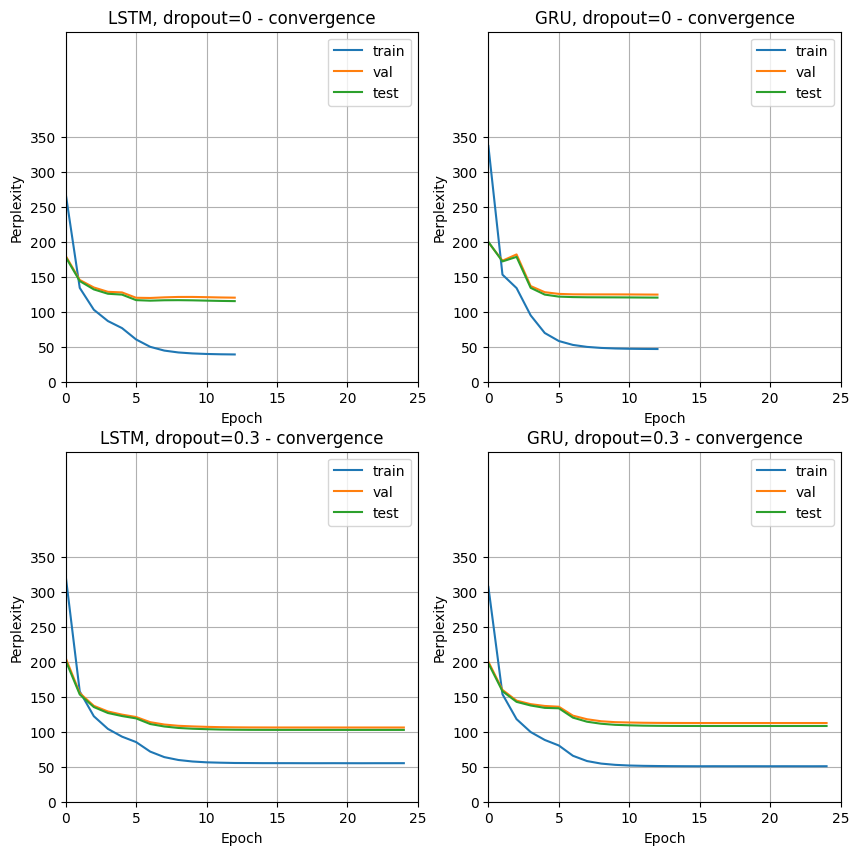

In [9]:
table = pd.DataFrame(data=None, columns=['train ppl', 'val ppl', 'test ppl'])

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for j, rnn in enumerate(RecurrentUnit):
  for i, dropout_rate in enumerate([0, 0.3]):

    # use a fixed seed
    torch.manual_seed(7)

    model_name = f'{rnn.name}, dropout={dropout_rate}'
    print(f"Model {model_name}:")
    print(f"-------------------------------------------------------------------------------------")

    model = RNN(dropout_rate, rnn, vocab_size, rnn_size, init_weight, layers).to(device)
    train_ppl, val_ppl, test_ppl = train(model)

    print(f"-------------------------------------------------------------------------------------")
    print()

    ax[i, j].plot(train_ppl, label='train')
    ax[i, j].plot(val_ppl, label='val')
    ax[i, j].plot(test_ppl, label='test')
    ax[i, j].set_title(model_name + ' - convergence')
    ax[i, j].set_xlabel('Epoch')
    ax[i, j].set_ylabel('Perplexity')
    ax[i, j].set_xlim(0, 25)
    ax[i, j].set_ylim(0, 500)
    ax[i, j].set_yticks(np.arange(0, 400, 50))
    ax[i, j].grid()
    ax[i, j].legend()

    table.loc[model_name] = [train_ppl[-1], val_ppl[-1], test_ppl[-1]]
    torch.save(model.state_dict(), data_root_dir + f"saved_models/{rnn.name}_dropout{dropout_rate}")
    print()

plt.show()

In [13]:
print(table)

                   train ppl     val ppl    test ppl
LSTM, dropout=0    38.955662  120.080254  115.151344
LSTM, dropout=0.3  55.061382  106.023727  102.596283
GRU, dropout=0     46.711441  124.449173  120.154945
GRU, dropout=0.3   50.715004  112.424774  108.192528


# Saved Models - Evaluation

In [12]:
def load_inference_model(dropout: float, unit_type: RecurrentUnit=RecurrentUnit.LSTM):
  """
  def load_inference_model(reg_type: RegType=RegType.NONE)
  : param dropout : float dropout rate used by the model
  : param unit_type: RecurrentUnit - RNN cell used in the model

  : return : RNN trained model
  """
  model = RNN(dropout, unit_type, vocab_size, rnn_size, init_weight, layers).to(device)
  if unit_type is RecurrentUnit.LSTM:
    PATH = data_root_dir + f"saved_models/LSTM_dropout{dropout}"
  else:
    PATH = data_root_dir + f"saved_models/GRU_dropout{dropout}"

  model.load_state_dict(torch.load(PATH))
  return model

In [11]:
criterion = nn.CrossEntropyLoss()
for dropout in [0, max_dropout]:
  for unit_type in RecurrentUnit:
    model = load_inference_model(dropout=dropout, unit_type=unit_type)
    test_ppl  = eval_iter(model, criterion, test_tokens)
    print(f"model: {unit_type} with dropout={dropout} acheived perplexity: {test_ppl:.3f}")

model: RecurrentUnit.LSTM with dropout=0 acheived perplexity: 115.151
model: RecurrentUnit.GRU with dropout=0 acheived perplexity: 120.155
model: RecurrentUnit.LSTM with dropout=0.3 acheived perplexity: 102.596
model: RecurrentUnit.GRU with dropout=0.3 acheived perplexity: 108.193
